In [1]:
import xarray as xr
import ee
import contextily as ctx
import os
from dotenv import load_dotenv
import geopandas as gpd
from me_resources.resources import get_credentials
from me_resources.object_storages import get_s3_filesystem, get_s3_client
import dask.distributed
import pandas_geojson as pdg
import pandas as pd
from geomob import create_geometry
from datetime import datetime
import datetime as dt
import numpy as np
from tqdm import tqdm
from pandarallel import pandarallel
from shapely import geometry
from me_gee.roadsegments import eeCollectionOnLine

In [2]:
zone = 'COPE' #IT, DK, ITTEST etc...
scale = 0.001
path = '/home/alessandro/RoadSample/cartonbs-road-regression'

In [3]:
#set the credentials for the minio bucket
load_dotenv(path+'/.env')
os.environ['MINIO_ACCESS_KEY_ID']=os.getenv("access_id")
os.environ['MINIO_SECRET_ACCESS_KEY']=os.getenv("secret_key")
#create the s3 filesystem
fs = get_s3_filesystem(get_credentials('minio'))
s3 = get_s3_client(get_credentials('minio'))

In [4]:
# initialize Earth Engine:
def ee_init():
    ee.Authenticate()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [5]:
#initialize dask client and ee in each worker
client = dask.distributed.Client()
client.run(ee_init)
ee_init()
client

/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41547 instead
  warnings.warn(
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init
*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtr

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41547/status,
Dashboard: http://127.0.0.1:41547/status,Workers: 6
Total threads: 24,Total memory: 47.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40709,Workers: 6
Dashboard: http://127.0.0.1:41547/status,Total threads: 24
Started: Just now,Total memory: 47.04 GiB
Comm: tcp://127.0.0.1:41339,Total threads: 4
Dashboard: http://127.0.0.1:36295/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:45349,


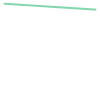

In [6]:
#import data
covariates_geojson=pdg.read_geojson(path+'/roads/mean_by_timeframe_lines.geojson')
#create geometry column from geojson features
geoms = [create_geometry(x['geometry']) for x in covariates_geojson.to_dict()['features']]
geoms[0]

In [7]:
#create geodataframe from geometries
covariates_df=covariates_geojson.to_dataframe()
covariates_df['geometry']=geoms
covariates_gdf = gpd.GeoDataFrame(covariates_df.drop(columns=['type', 'geometry.type', 'geometry.coordinates']),crs='EPSG:4326')
covariates_gdf


,properties.osm_id,properties.code,properties.fclass,properties.name,properties.t,properties.h,properties.p,properties.pm1,properties.pm25,properties.pm10,...,properties.pm25_7am-10am,properties.t_10am-1pm,properties.t_1pm-4pm,properties.t_4pm-7pm,properties.t_7am-10am,properties.voc_10am-1pm,properties.voc_1pm-4pm,properties.voc_4pm-7pm,properties.voc_7am-10am,geometry
0,30628338,5122.0,residential,None,31.916667,59.250000,1004.858333,12.490071,15.159208,17.025666,...,24.270244,33.000000,33.285714,31.333333,29.400000,0.037500,0.031286,0.055000,0.081000,"LINESTRING (-4.09882 5.35319, -4.09882 5.35319..."
1,596014375,5122.0,residential,None,31.955556,59.533333,1005.426667,13.691211,16.473373,18.422170,...,19.269024,33.411765,32.250000,31.200000,30.000000,0.068294,0.050875,0.053900,0.089900,"LINESTRING (-4.09737 5.35111, -4.09739 5.35111..."
2,30610653,5122.0,residential,None,32.321429,58.428571,1005.282143,14.582088,17.477531,19.483224,...,19.787805,33.846154,32.000000,31.333333,29.800000,0.080000,0.041750,0.065000,0.071800,"LINESTRING (-4.09736 5.35053, -4.09736 5.35053..."
3,30630789,5122.0,residential,None,32.200000,58.960000,1005.504000,12.651018,15.421389,17.416319,...,19.787805,33.666667,32.000000,31.500000,30.142857,0.089833,0.055000,0.049000,0.095429,"LINESTRING (-4.09685 5.35053, -4.09733 5.35053..."
4,30611927,5115.0,tertiary,None,31.700637,60.159236,1005.941401,13.076909,15.437738,16.968895,...,19.991786,32.545455,33.139535,31.100000,29.675000,0.030955,0.024977,0.038600,0.109250,"LINESTRING (-4.09943 5.34699, -4.09943 5.34722..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,323666570,5122.0,residential,None,31.863636,66.181818,999.900000,28.149989,32.732081,35.965223,...,59.695315,33.200000,34.428571,29.000000,29.571429,0.016400,0.020857,0.011667,0.019571,"LINESTRING (-4.01196 5.44834, -4.01209 5.44779..."
200,501382092,5115.0,tertiary,Route Akéikoi,32.268139,66.485804,999.830126,40.104184,45.045108,47.872036,...,73.389010,34.520000,34.686747,28.533333,29.370787,0.039980,0.037398,0.029400,0.045539,"LINESTRING (-4.01442 5.44609, -4.01442 5.44609..."
201,94123694,5115.0,tertiary,None,32.166667,56.812500,999.641667,47.071483,52.533749,55.644305,...,88.826632,34.333333,34.428571,31.222222,28.384615,0.017417,0.016286,0.025222,0.069538,"LINESTRING (-4.01375 5.41148, -4.01329 5.41142..."
202,94563388,5122.0,residential,None,32.047619,57.285714,999.504762,28.806812,33.572179,37.028391,...,61.902950,34.400000,34.000000,30.666667,29.285714,0.017600,0.010833,0.010000,0.038714,"LINESTRING (-4.01053 5.41182, -4.00993 5.41182)"


In [8]:
bounding_box = geometry.box(*covariates_gdf.total_bounds)
bbox=gpd.GeoDataFrame(geometry=gpd.GeoSeries(gpd.GeoSeries([bounding_box])),crs='EPSG:4326')
AOI = ee.Geometry.Rectangle(*covariates_gdf.total_bounds)
bbox.explore()

In [9]:
line=ee.Geometry.LineString(list(covariates_gdf.geometry[0].coords))

In [10]:
date='2023-01-01'
#convert dates to datetime
datesdt = datetime.strptime(date, '%Y-%m-%d')
dateplusone = datesdt + dt.timedelta(days=1)
dateplusone = dateplusone.strftime('%Y-%m-%d')

**RASTER SAMPLE OVER SEGMENT**

In [ ]:
covariates=covariates_df.copy()
datasets=['COPERNICUS/S5P/OFFL/L3_NO2','COPERNICUS/S5P/OFFL/L3_O3','COPERNICUS/S5P/OFFL/L3_NO2','ECMWF/ERA5_LAND/HOURLY','ECMWF/ERA5_LAND/HOURLY','ECMWF/ERA5_LAND/HOURLY','MODIS/061/MOD13Q1']
bands=['NO2_column_number_density','O3_column_number_density','cloud_fraction','temperature_2m','surface_net_solar_radiation','total_precipitation','NDVI']
date_range=[date,dateplusone]
#datasets=["ESA/WorldCover/v100"]
#bands=['Map']
amodes='mean'
segment_values = []
pandarallel.initialize(progress_bar=True)
for dataset,band in zip(datasets,bands):
    segment_values=covariates_df['geometry.coordinates'].parallel_apply(lambda row: eeCollectionOnLine(eepath=dataset,date_range=date_range, band=band,line=ee.Geometry.LineString(row),aggregationMode=amodes,isCollection=True))
    covariates[band]=segment_values
covariates

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean

/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(array)
/home/alessandro/Citynexus/CEnviron/lib/python3.9/site-packages/me_gee/helpers.py:21: RuntimeWarning: Mean

In [ ]:
covariates['Map'].unique()

array([50])